In [1201]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# This notebook illustrates some results of optimizing the inner and outer functions when theta is a line

In [1202]:
from OT_losses_and_grad import F, G, F_eps, G_eps, theta2w, grad_G_eps_Stein, grad_F_eps
import numpy as np
import ot
import matplotlib.pyplot as plt
import time
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix, make_sparse_spd_matrix
from matplotlib.gridspec import GridSpec
plt.rcParams['figure.figsize'] = [5, 3]


### Useful function to sample distributions

true Wass distance 386.0094360068199


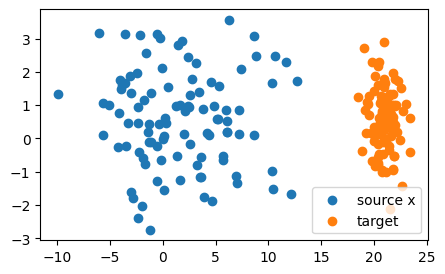

In [1255]:

def draw_samples(n, d, seed=0, type_distrib='gauss'):

    np.random.seed(seed)

    if type_distrib == 'gauss':
        # Gaussian distributions
        if d == 1: #samples in 2d but theta in 1d (direction)
            mu_s = np.array([0, 0])
            cov_s = np.array([[1, 0], [0, 1]])

            mu_t = np.array([4, 4])
            cov_t = np.array([[1, -0.8], [-0.8, 1]])

            x = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
            y = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
        else:
            cov_x = make_sparse_spd_matrix(n_dim=d, random_state=42,alpha=0.99, smallest_coef=0, largest_coef=0.22)
            diag_x = np.eye(d)
            for i in range(d//2):
                diag_x[i,i] = 20
            cov_x = cov_x + diag_x
            #cov_x[1,1] = 20
            mu_x = np.random.randn(d)
            x = np.random.multivariate_normal(mu_x, cov_x, size=n)
            cov_y = np.eye(d)
            cov_y = make_sparse_spd_matrix(n_dim=d, random_state=43)
            mu_y =  np.random.randn(d) 
            mu_y[0:d//2] =  mu_y[0:d//2] + 20
            #mu_y[0] =  mu_y[0] + 10 #1dim is the most important
            y = np.random.multivariate_normal(mu_y, cov_y, size=n)  
    elif type_distrib == 'other_gauss': #weird distribution!
        if d == 1:
            d = 2
        x = (np.random.randn(n, d))
        x[0,:] = x[0,:] + 5
        y = np.random.randn(n, d)
    elif type_distrib == 'uniform':
        if d == 1:
            d = 2
        #or random distributions
        x = np.random.uniform(size=n * d).reshape(n, d)
        x[:, 0] = x[:, 0] + 2 #make the 2 distributions far away on one axis
        y = np.random.uniform(size=n*d).reshape(n, d)
    else:
        raise ValueError('type_distrib not recognized')

    C = ot.dist(x,y)

    print("true Wass distance", ot.emd2([], [], C))
    return x, y

n = 100
seed = 0
d = 2
type_distribs = 'gauss'
x, y = draw_samples(n, d, seed, type_distribs)

plt.scatter(x[:,0], x[:,1], label='source x')
plt.scatter(y[:,0], y[:,1], label='target')
plt.legend()
plt.show()



### Useful function to draw a line of direction $\theta$

In [1204]:
def plot_line(x, y, theta, alpha=1, color="r"):
    x_min = np.min([np.min(x[:,0]), np.min(y[:,0])])
    y_min = np.min([np.min(x[:,1]), np.min(y[:,1])])
    x_max = np.max([np.max(x[:,0]), np.max(y[:,0])])
    y_max = np.max([np.max(x[:,1]), np.max(y[:,1])])
    w_max = theta2w(theta)*np.max([x_max, y_max])
    w_min = theta2w(theta)*np.min([x_min, y_min])
    plt.plot([w_min[0],w_max[0]], [w_min[1], w_max[1]], color, alpha=alpha, label='theta = {}'.format(np.round(theta,2)))
    

### Compute objective value + grad of inner (G) and outer (F) functions

In [1205]:
def inner_values(x, y, thetas, n_samples, epsilon_g):
    Gs = [G(x, y, theta) for theta in thetas]
    Gs_eps = [G_eps(x, y, theta, epsilon_g, n_samples) for theta in thetas]
    grad_Gs_eps = [grad_G_eps_Stein(x, y, theta, epsilon_g, n_samples) for theta in thetas]
    return Gs, Gs_eps, grad_Gs_eps

def outer_values(x, y, thetas, n_samples, epsilon_f):
    Fs =  [F(x, y, theta) for theta in thetas]
    Fs_eps =  [F_eps(x, y, theta, epsilon_f, n_samples) for theta in thetas]
    grad_Fs_eps = [grad_F_eps(x, y, theta, epsilon_f, n_samples) for theta in thetas]
    return Fs, Fs_eps, grad_Fs_eps

# 1. Optimisation de la fonction G (inner)



## 1.1. Discontinuités et non convexité de la fonction G (inner) - Figure 1 du typst

### For gaussian distributions

true Wass distance 23.43583803331571
true Wass distance 32.426755818220954


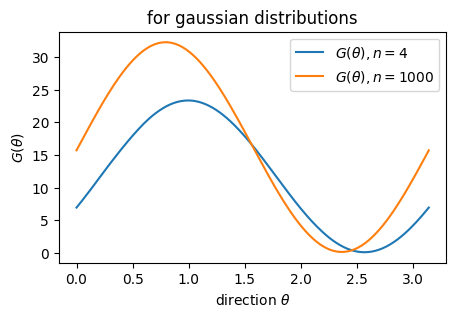

In [1265]:
thetas = np.linspace(0, np.pi, num=200) #symmetric: only consider half of the circle
epsilon_g = 0.1
n_samples = 1 #not used here 
type_distribs = 'gauss'
d = 1

# small number of samples
n = 4
x_gauss, y_gauss = draw_samples(n, d, seed, type_distribs)
Gs, Gs_eps, grad_Gs_eps = inner_values(x_gauss, y_gauss, thetas, n_samples, epsilon_g)
plt.plot(thetas, Gs, label=f"$G(\\theta), n={n}$")

# larger number of samples
n = 1000
x_gauss, y_gauss = draw_samples(n, d, seed, type_distribs)
Gs, Gs_eps, grad_Gs_eps = inner_values(x_gauss, y_gauss, thetas, n_samples, epsilon_g)
plt.plot(thetas, Gs, label=f"$G(\\theta), n={n}$")

plt.title(f"for gaussian distributions")
plt.xlabel("direction $\\theta$")
plt.ylabel("$G(\\theta)$")
plt.legend()
plt.show()

### For uniform distributions

true Wass distance 3.794536638404325
true Wass distance 4.015039060245258


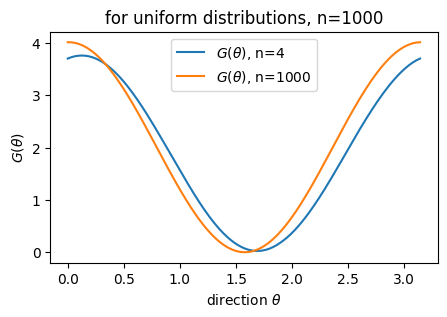

In [ ]:
type_distribs = 'uniform'

n = 4
x_unif, y_unif = draw_samples(n, d, seed, type_distribs)
Gs, Gs_eps, grad_Gs_eps = inner_values(x_unif, y_unif, thetas, n_samples, epsilon_g)
plt.plot(thetas, Gs, label=f"$G(\\theta)$, n={n}")

n = 1000
x_unif, y_unif = draw_samples(n, d, seed, type_distribs)
Gs, Gs_eps, grad_Gs_eps = inner_values(x_unif, y_unif, thetas, n_samples, epsilon_g)
plt.plot(thetas, Gs, label=f"$G(\\theta)$, n={n}")

plt.title(f"for uniform distributions, n={n}")
plt.xlabel("direction $\\theta$")
plt.ylabel("$G(\\theta)$")
plt.legend()
plt.show()


### For the weid Gaussian distribution (= Gaussian distribs + 1 outlier) => non convexity of the objective function + discontinuities

true Wass distance 11.388178560358112


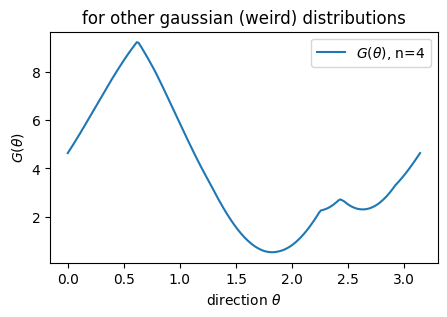

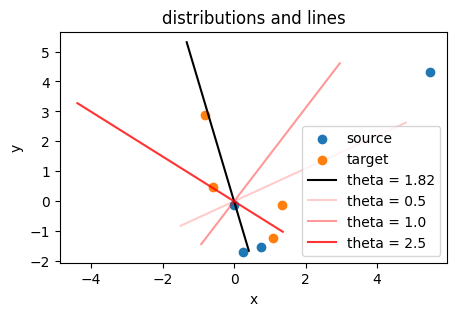

In [1272]:
type_distribs = 'other_gauss'

n = 4
x_other, y_other = draw_samples(n, d, 12, type_distribs)
Gs, Gs_eps, grad_Gs_eps = inner_values(x_other, y_other, thetas, n_samples, epsilon_g)
plt.plot(thetas, Gs, label=f"$G(\\theta)$, n={n}")

plt.title(f"for other gaussian (weird) distributions")
plt.xlabel("direction $\\theta$")
plt.ylabel("$G(\\theta)$")
plt.legend()
plt.show()
plt.scatter(x_other[:,0], x_other[:,1], label='source')
plt.scatter(y_other[:,0], y_other[:,1], label='target')
plot_line(x_other, y_other, thetas[np.argmin(Gs)], alpha=1, color="k")
plot_line(x_other, y_other, np.float64(0.5), alpha=0.2)
plot_line(x_other, y_other, np.float64(1), alpha=0.4)
plot_line(x_other, y_other, np.float64(2.5), alpha=0.8)
plt.title("distributions and lines")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Note that this example is for "illustration purpose": we have here $\mu = \nu$, expect for 1 sample => the Wasserstein distance is then close to 0 and every line should give a good approximation

## 1.2. Optimisation de la fonction G (inner): visualisation sur la courbe G

### for uniform distributions

true Wass distance 4.069835761866888


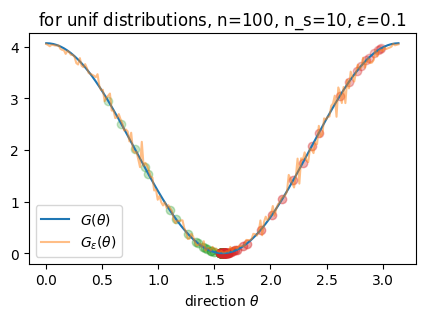

In [1273]:
n = 100
epsilon_g = 0.1
n_samples = 10
x_gauss, y_gauss = draw_samples(n, d, seed, "uniform")

Gs, Gs_eps, grad_Gs_eps = inner_values(x_gauss, y_gauss, thetas, n_samples, epsilon_g)

plt.plot(thetas, Gs, label="$G(\\theta)$")
plt.plot(thetas, Gs_eps, label="$G_\\varepsilon(\\theta)$", alpha=0.5)
plt.title(f"for unif distributions, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_g}")
plt.xlabel("direction $\\theta$")
plt.legend()

lr_g = 0.025 #learning rate for G

round1 = True
for th in [0.5, 3]:
  th_g = np.float64(th)
  nb_steps = 50
  for i in range(nb_steps):
      g = grad_G_eps_Stein(x_gauss, y_gauss, th_g, epsilon_g, n_samples)
      th_g = th_g - lr_g * g
      if round1:
        plt.scatter(th_g, G(x_gauss, y_gauss, th_g), c = "C2", alpha = 0.25+i/nb_steps/2)
      else:
        plt.scatter(th_g, G(x_gauss, y_gauss, th_g), c = "C3", alpha = 0.25+i/nb_steps/2)
  round1 = False
plt.show()


### for gaussian distributions

true Wass distance 0.47398291150402044


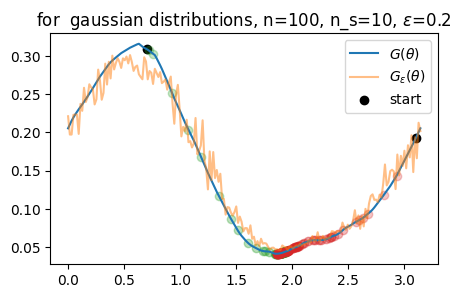

In [1290]:
type_distribs = 'other_gauss'
n = 100
epsilon_g = 0.2
n_samples = 10
d = 1
x_gauss, y_gauss = draw_samples(n, d, 12, 'other_gauss')

Gs, Gs_eps, grad_Gs_eps = inner_values(x_gauss, y_gauss, thetas, n_samples, epsilon_g)

plt.plot(thetas, Gs, label="$G(\\theta)$")
plt.plot(thetas, Gs_eps, label="$G_\\varepsilon(\\theta)$", alpha=0.5)
plt.title(f"for  gaussian distributions, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_g}")
plt.legend()

lr_g = 0.5 #learning rate for G

round1 = True
for th in [0.7, 3.1]:
  th_g = np.float64(th)
  nb_steps = 50
  if round1:
    plt.scatter(th_g, G(x_gauss, y_gauss, th_g), c = "k", label="start")
  else:
    plt.scatter(th_g, G(x_gauss, y_gauss, th_g), c = "k")
  for i in range(nb_steps):
      g = grad_G_eps_Stein(x_gauss, y_gauss, th_g, epsilon_g, n_samples)
      th_g = th_g - lr_g * g
      if round1:
        plt.scatter(th_g, G(x_gauss, y_gauss, th_g), c = "C2", alpha = 0.25+i/nb_steps/2)
      else:
        plt.scatter(th_g, G(x_gauss, y_gauss, th_g), c = "C3", alpha = 0.25+i/nb_steps/2)
  round1 = False
plt.legend()
plt.show()


## 1.3. Optimisation de la fonction G (inner): décroissance de la loss -- en 1d

Now, let's see the evolution of the value function across the iterations with various parameters

### For uniform distributions

true Wass distance 4.069835761866888


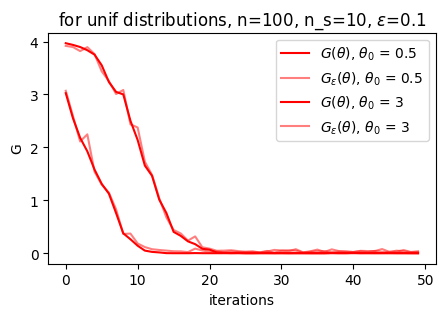

In [1281]:
n = 100
epsilon_g = 0.1
n_samples = 10
d = 1
x_gauss, y_gauss = draw_samples(n, d, seed, "uniform")

lr_g = 0.025 #learning rate for G


all_Gs = []
all_Gs_eps = []
for th in [0.5, 3]:
  th_g = np.float64(th)
  nb_steps = 50
  for i in range(nb_steps):
      g = grad_G_eps_Stein(x_gauss, y_gauss, th_g, epsilon_g, n_samples)
      th_g = th_g - lr_g * g
      all_Gs.append(G(x_gauss, y_gauss, th_g))
      all_Gs_eps.append(G_eps(x_gauss, y_gauss, th_g, epsilon_g, n_samples))
  plt.plot(np.arange(nb_steps), all_Gs, "r", label="$G(\\theta)$, $\\theta_0$ = {}".format(th))
  plt.plot(np.arange(nb_steps), all_Gs_eps, "r", alpha = 0.5, label="$G_\\varepsilon(\\theta)$, $\\theta_0$ = {}".format(th))
  all_Gs = []
  all_Gs_eps = []
plt.legend()
plt.xlabel("iterations")
plt.ylabel("G")
plt.title(f"for unif distributions, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_g}")
plt.show()


true Wass distance 4.015039060245258


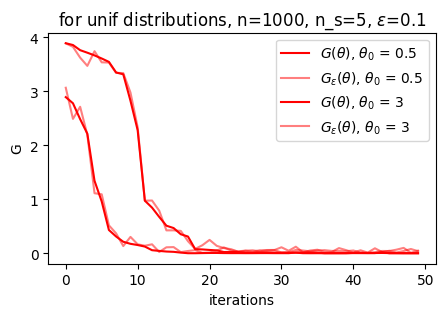

In [1284]:
n = 1000
epsilon_g = 0.1
n_samples = 5
x_gauss, y_gauss = draw_samples(n, d, seed, "uniform")

lr_g = 0.025 #learning rate for G


all_Gs = []
all_Gs_eps = []
for th in [0.5, 3]:
  th_g = np.float64(th)
  nb_steps = 50
  for i in range(nb_steps):
      g = grad_G_eps_Stein(x_gauss, y_gauss, th_g, epsilon_g, n_samples)
      th_g = th_g - lr_g * g
      all_Gs.append(G(x_gauss, y_gauss, th_g))
      all_Gs_eps.append(G_eps(x_gauss, y_gauss, th_g, epsilon_g, n_samples))
  plt.plot(np.arange(nb_steps), all_Gs, "r", label="$G(\\theta)$, $\\theta_0$ = {}".format(th))
  plt.plot(np.arange(nb_steps), all_Gs_eps, "r", alpha = 0.5, label="$G_\\varepsilon(\\theta)$, $\\theta_0$ = {}".format(th))
  all_Gs = []
  all_Gs_eps = []
plt.legend()
plt.xlabel("iterations")
plt.ylabel("G")
plt.title(f"for unif distributions, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_g}")
plt.show()


true Wass distance 4.069835761866888


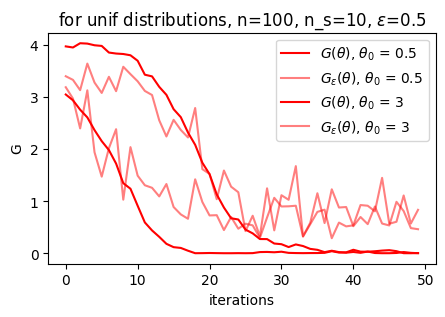

In [1291]:
n = 100
epsilon_g = 0.5
n_samples = 10
x_gauss, y_gauss = draw_samples(n, d, seed, "uniform")

lr_g = 0.025 #learning rate for G


all_Gs = []
all_Gs_eps = []
for th in [0.5, 3]:
  th_g = np.float64(th)
  nb_steps = 50
  for i in range(nb_steps):
      g = grad_G_eps_Stein(x_gauss, y_gauss, th_g, epsilon_g, n_samples)
      th_g = th_g - lr_g * g
      all_Gs.append(G(x_gauss, y_gauss, th_g))
      all_Gs_eps.append(G_eps(x_gauss, y_gauss, th_g, epsilon_g, n_samples))
  plt.plot(np.arange(nb_steps), all_Gs, "r", label="$G(\\theta)$, $\\theta_0$ = {}".format(th))
  plt.plot(np.arange(nb_steps), all_Gs_eps, "r", alpha = 0.5, label="$G_\\varepsilon(\\theta)$, $\\theta_0$ = {}".format(th))
  all_Gs = []
  all_Gs_eps = []
plt.legend()
plt.xlabel("iterations")
plt.ylabel("G")
plt.title(f"for unif distributions, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_g}")
plt.show()


true Wass distance 4.015039060245258


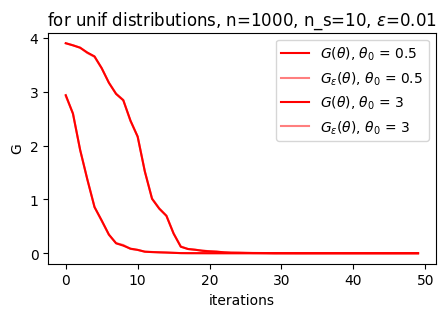

In [1292]:
n = 1000
epsilon_g = 0.01
n_samples = 10
x_gauss, y_gauss = draw_samples(n, d, seed, "uniform")

lr_g = 0.025 #learning rate for G


all_Gs = []
all_Gs_eps = []
for th in [0.5, 3]:
  th_g = np.float64(th)
  nb_steps = 50
  for i in range(nb_steps):
      g = grad_G_eps_Stein(x_gauss, y_gauss, th_g, epsilon_g, n_samples)
      th_g = th_g - lr_g * g
      all_Gs.append(G(x_gauss, y_gauss, th_g))
      all_Gs_eps.append(G_eps(x_gauss, y_gauss, th_g, epsilon_g, n_samples))
  plt.plot(np.arange(nb_steps), all_Gs, "r", label="$G(\\theta)$, $\\theta_0$ = {}".format(th))
  plt.plot(np.arange(nb_steps), all_Gs_eps, "r", alpha = 0.5, label="$G_\\varepsilon(\\theta)$, $\\theta_0$ = {}".format(th))
  all_Gs = []
  all_Gs_eps = []
plt.legend()
plt.xlabel("iterations")
plt.ylabel("G")
plt.title(f"for unif distributions, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_g}")
plt.show()


### and for Gaussian distributions

true Wass distance 30.536014353506197


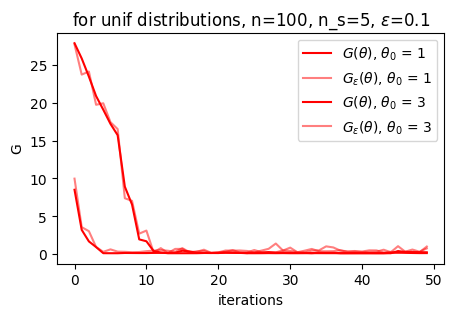

In [1293]:
n = 100
epsilon_g = 0.1
n_samples = 5
d = 1
x_gauss, y_gauss = draw_samples(n, d, seed, "gauss")

lr_g = 0.005 #learning rate for G


all_Gs = []
all_Gs_eps = []
for th in [1, 3]:
  th_g = np.float64(th)
  nb_steps = 50
  for i in range(nb_steps):
      g = grad_G_eps_Stein(x_gauss, y_gauss, th_g, epsilon_g, n_samples)
      th_g = th_g - lr_g * g
      all_Gs.append(G(x_gauss, y_gauss, th_g))
      all_Gs_eps.append(G_eps(x_gauss, y_gauss, th_g, epsilon_g, n_samples))
  plt.plot(np.arange(nb_steps), all_Gs, "r", label="$G(\\theta)$, $\\theta_0$ = {}".format(th))
  plt.plot(np.arange(nb_steps), all_Gs_eps, "r", alpha = 0.5, label="$G_\\varepsilon(\\theta)$, $\\theta_0$ = {}".format(th))
  all_Gs = []
  all_Gs_eps = []
plt.legend()
plt.xlabel("iterations")
plt.ylabel("G")
plt.title(f"for unif distributions, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_g}")
plt.show()


## 1.4. Optimisation de la fonction G (inner): décroissance de la loss -- pour $d \geq 2$
Un exemple en dimension 100

lull
true Wass distance 21325.558036971706


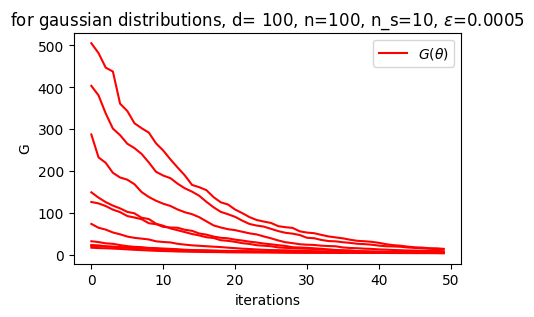

In [1240]:
n = 100
epsilon_g = 0.0005
n_samples = 10
d = 100
x_gauss, y_gauss = draw_samples(n, d, seed, "gauss")

lr_g = 0.000001 #learning rate for G


all_Gs = []
all_Gs_eps = []
nb_reps = 10
for th in range(nb_reps):
  th_g = np.random.randn(d)
  th_g = th_g / np.sqrt(np.sum(th_g**2)) 
  #print("estimated W with the initial theta value", F(x_gauss, y_gauss, th_g))
  nb_steps = 50
  for i in range(nb_steps):
      g = grad_G_eps_Stein(x_gauss, y_gauss, th_g, epsilon_g, n_samples)
      th_g = th_g - lr_g * g
      #th_g = th_g / np.sqrt(np.sum(th_g**2)) 
      all_Gs.append(G(x_gauss, y_gauss, th_g))
      all_Gs_eps.append(G_eps(x_gauss, y_gauss, th_g, epsilon_g, n_samples))
  if th == 0:
    plt.plot(np.arange(nb_steps), all_Gs, "r", label="$G(\\theta)$")
  else:
    plt.plot(np.arange(nb_steps), all_Gs, "r")
  #plt.plot(np.arange(nb_steps), all_Gs_eps, "r", alpha = 0.5, label="$G_\\varepsilon(\\theta)$, $\\theta_0$ = {}".format(th))
  #print("estimated W with the last theta value", F(x_gauss, y_gauss, th_g))
  all_Gs = []
  all_Gs_eps = []
plt.legend()
plt.xlabel("iterations")
plt.ylabel("G")
plt.title(f"for gaussian distributions, d= {d}, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_g}")
plt.show()


# 2. Optimisation de la fonction F (outer)



## 2.1. Discontinuités et non convexité de la fonction F

true Wass distance 23.43583803331571


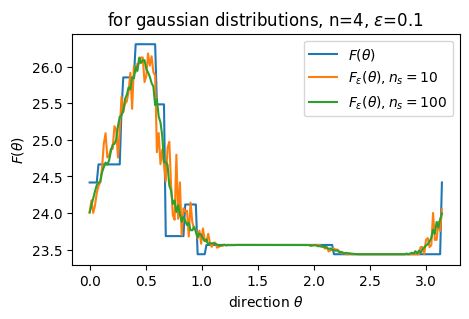

In [1294]:
thetas = np.linspace(0, np.pi, num=200) 
epsilon_f = 0.1

type_distribs = 'gauss'
n = 4
d = 1
x_gauss, y_gauss = draw_samples(n, d, seed, type_distribs)

n_samples = 10
Fs, Fs_eps, grad_Fs_eps = outer_values(x_gauss, y_gauss, thetas, n_samples, epsilon_f)
plt.plot(thetas, Fs, label="$F(\\theta)$")
plt.plot(thetas, Fs_eps, label=f"$F_\\varepsilon(\\theta), n_s={n_samples}$")

n_samples = 100
Fs, Fs_eps, grad_Fs_eps = outer_values(x_gauss, y_gauss, thetas, n_samples, epsilon_g)
plt.plot(thetas, Fs_eps, label=f"$F_\\varepsilon(\\theta), n_s={n_samples}$")


plt.title(f"for gaussian distributions, n={n}, $\\varepsilon$={epsilon_g}")
plt.xlabel("direction $\\theta$")
plt.ylabel("$F(\\theta)$")
plt.legend()
plt.show()



true Wass distance 21.813006336512565


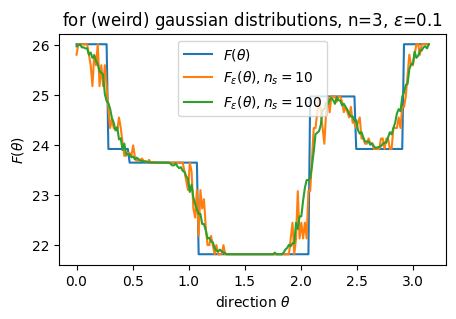

In [ ]:
thetas = np.linspace(0, np.pi, num=200) #symmetric: only consider half of the circle
epsilon_f = 0.1
epsilon_g = 0.1
n_samples = 1
type_distribs = 'other_gauss'
n = 3
d = 1
x_gauss, y_gauss = draw_samples(n, d, seed, type_distribs)

n_samples = 10
Fs, Fs_eps, grad_Fs_eps = outer_values(x_gauss, y_gauss, thetas, n_samples, epsilon_g)
plt.plot(thetas, Fs, label="$F(\\theta)$")
plt.plot(thetas, Fs_eps, label=f"$F_\\varepsilon(\\theta), n_s={n_samples}$")

n_samples = 100
Fs, Fs_eps, grad_Fs_eps = outer_values(x_gauss, y_gauss, thetas, n_samples, epsilon_g)
plt.plot(thetas, Fs_eps, label=f"$F_\\varepsilon(\\theta), n_s={n_samples}$")
plt.title(f"for (weird) gaussian distributions, n={n}, $\\varepsilon$={epsilon_g}")


plt.xlabel("direction $\\theta$")
plt.ylabel("$F(\\theta)$")
plt.legend()
plt.show()

true Wass distance 30.536014353506197


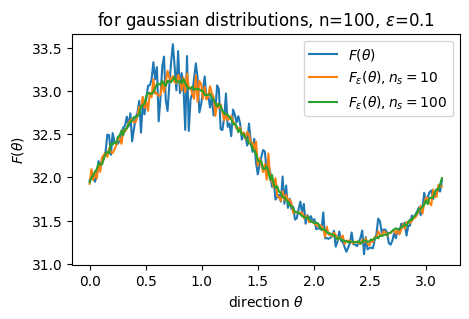

In [1297]:
thetas = np.linspace(0, np.pi, num=200) #symmetric: only consider half of the circle
epsilon_f = 0.1
type_distribs = 'gauss'

n = 100
d = 1
x_gauss, y_gauss = draw_samples(n, d, seed, type_distribs)

n_samples = 10
Fs, Fs_eps, grad_Fs_eps = outer_values(x_gauss, y_gauss, thetas, n_samples, epsilon_f)
plt.plot(thetas, Fs, label="$F(\\theta)$")
plt.plot(thetas, Fs_eps, label=f"$F_\\varepsilon(\\theta), n_s={n_samples}$")
n_samples = 100
Fs, Fs_eps, grad_Fs_eps = outer_values(x_gauss, y_gauss, thetas, n_samples, epsilon_f)
plt.plot(thetas, Fs_eps, label=f"$F_\\varepsilon(\\theta), n_s={n_samples}$")
plt.title(f"for gaussian distributions, n={n}, $\\varepsilon$={epsilon_f}")

plt.xlabel("direction $\\theta$")
plt.ylabel("$F(\\theta)$")
plt.legend()
plt.show()



## 2.2. Optimisation de la fonction F (outer): visualisation sur la courbe F

### For gaussian distributions

true Wass distance 30.536014353506197


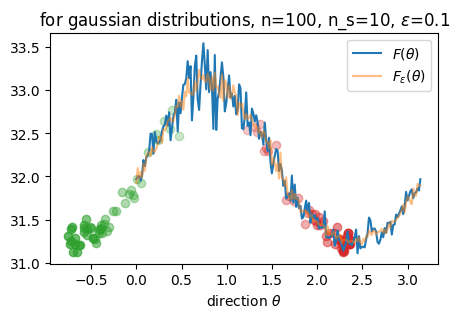

In [1299]:
n = 100
epsilon_f = 0.1
n_samples = 10
x_gauss, y_gauss = draw_samples(n, d, seed, "gauss")

Fs, Fs_eps, grad_Fs_eps = outer_values(x_gauss, y_gauss, thetas, n_samples, epsilon_f)

plt.plot(thetas, Fs, label="$F(\\theta)$")
plt.plot(thetas, Fs_eps, label="$F_\\varepsilon(\\theta)$", alpha=0.5)
plt.title(f"for gaussian distributions, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_f}")
plt.xlabel("direction $\\theta$")
plt.legend()

#optimization

lr_f = 0.025 #learning rate for G
round1 = True
for th in [0.5, 1.1]:
  th_f = np.float64(th)
  nb_steps = 50
  for i in range(nb_steps):
      g = grad_F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples)
      th_f = th_f - lr_f * g
      if round1:
        plt.scatter(th_f, F(x_gauss, y_gauss, th_f), c = "C2", alpha = 0.25+i/nb_steps/2)
      else:
        plt.scatter(th_f, F(x_gauss, y_gauss, th_f), c = "C3", alpha = 0.25+i/nb_steps/2)
  round1 = False
plt.show()


true Wass distance 30.536014353506197


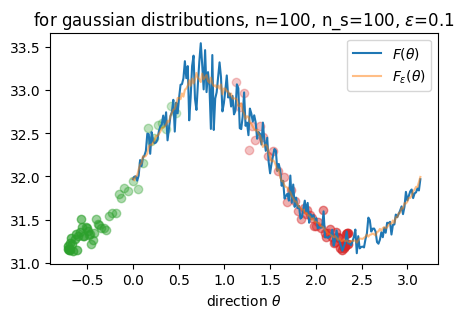

In [1300]:
n = 100
epsilon_f = 0.1
n_samples = 100
x_gauss, y_gauss = draw_samples(n, d, seed, "gauss")

Fs, Fs_eps, grad_Fs_eps = outer_values(x_gauss, y_gauss, thetas, n_samples, epsilon_f)

plt.plot(thetas, Fs, label="$F(\\theta)$")
plt.plot(thetas, Fs_eps, label="$F_\\varepsilon(\\theta)$", alpha=0.5)
plt.title(f"for gaussian distributions, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_f}")
plt.xlabel("direction $\\theta$")
plt.legend()

lr_f = 0.025 #learning rate for G

round1 = True
for th in [0.5, 1.1]:
  th_f = np.float64(th)
  nb_steps = 50
  for i in range(nb_steps):
      g = grad_F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples)
      th_f = th_f - lr_f * g
      if round1:
        plt.scatter(th_f, F(x_gauss, y_gauss, th_f), c = "C2", alpha = 0.25+i/nb_steps/2)
      else:
        plt.scatter(th_f, F(x_gauss, y_gauss, th_f), c = "C3", alpha = 0.25+i/nb_steps/2)
  round1 = False
plt.show()


### For uniform distributions

true Wass distance 4.015039060245258


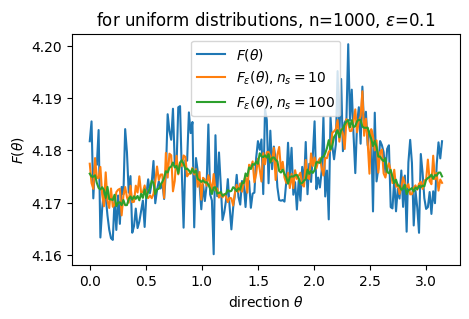

In [1301]:
thetas = np.linspace(0, np.pi, num=200) #symmetric: only consider half of the circle
epsilon_f = 0.1
type_distribs = 'uniform'
n = 1000
d = 1
x_gauss, y_gauss = draw_samples(n, d, seed, type_distribs)

n_samples = 10
Fs, Fs_eps, grad_Fs_eps = outer_values(x_gauss, y_gauss, thetas, n_samples, epsilon_f)
plt.plot(thetas, Fs, label="$F(\\theta)$")
plt.plot(thetas, Fs_eps, label=f"$F_\\varepsilon(\\theta), n_s={n_samples}$")
n_samples = 100
Fs, Fs_eps, grad_Fs_eps = outer_values(x_gauss, y_gauss, thetas, n_samples, epsilon_f)
plt.plot(thetas, Fs_eps, label=f"$F_\\varepsilon(\\theta), n_s={n_samples}$")
plt.title(f"for uniform distributions, n={n}, $\\varepsilon$={epsilon_f}")

plt.xlabel("direction $\\theta$")
plt.ylabel("$F(\\theta)$")
plt.legend()
plt.show()



true Wass distance 4.069835761866888


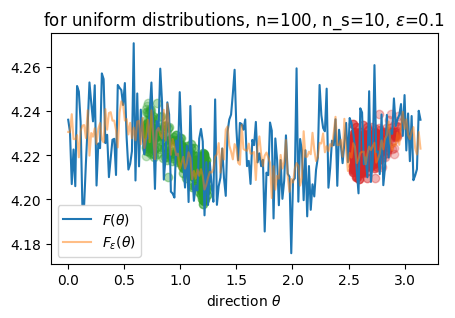

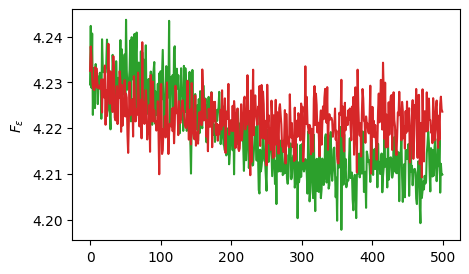

In [1303]:
n = 100
epsilon_f = .1
n_samples = 10
x_gauss, y_gauss = draw_samples(n, d, seed, "uniform")

Fs, Fs_eps, grad_Fs_eps = outer_values(x_gauss, y_gauss, thetas, n_samples, epsilon_f)

plt.plot(thetas, Fs, label="$F(\\theta)$")
plt.plot(thetas, Fs_eps, label="$F_\\varepsilon(\\theta)$", alpha=0.5)
plt.title(f"for uniform distributions, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_f}")
plt.xlabel("direction $\\theta$")
plt.legend()

lr_f = .05 #learning rate for G

round1 = True
round1_evol = []
round2_evol = []
for th in [0.7, 2.95]:
  th_f = np.float64(th)
  nb_steps = 500
  for i in range(nb_steps):
      g = grad_F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples)
      #print(g)
      th_f = th_f - lr_f * g
      obj = F_eps(x_gauss, y_gauss, th_f,  epsilon_f, n_samples)
      #obj = F(x_gauss, y_gauss, th_f)
      if round1:
        round1_evol.append(obj)
        plt.scatter(th_f, obj, c = "C2", alpha = 0.25+i/nb_steps/2)
      else:
        round2_evol.append(obj)
        plt.scatter(th_f, obj, c = "C3", alpha = 0.25+i/nb_steps/2)
  round1 = False
plt.show()

plt.plot(np.arange(nb_steps), round1_evol, "C2", label="$G(\\theta)$")
plt.plot(np.arange(nb_steps), round2_evol, "C3", label="$G(\\theta)$")
plt.ylabel(f"$F_\\varepsilon$")
plt.show()

## 2.3. Optimisation de la fonction F : décroissance de la loss -- pour $d \geq 2$

### déjà, en dimension 2 (sans se ramener à un problème de dimension 1)

true Wass distance 386.0094360068199


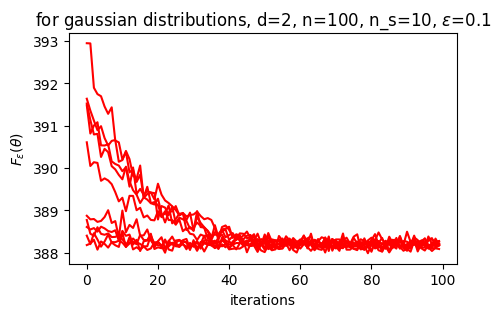

In [1309]:
n = 100
epsilon_f = 0.1
n_samples = 10
d = 2
x_gauss, y_gauss = draw_samples(n, d, seed, "gauss")

lr_f = 0.005 #learning rate for G


all_Fs = []
all_Fs_eps = []
nb_reps = 10
for th in range(nb_reps):
  th_f = np.random.randn(d)
  th_f = th_f / np.sqrt(np.sum(th_f**2)) 
  nb_steps = 100
  for i in range(nb_steps):
      g = grad_F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples)
      th_f = th_f - lr_f * g
      all_Fs.append(F(x_gauss, y_gauss, th_f))
      all_Fs_eps.append(F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples))
  if th == 0:
    plt.plot(np.arange(nb_steps), all_Fs_eps, "r")
  else:
    plt.plot(np.arange(nb_steps), all_Fs_eps, "r")
  all_Fs = []
  all_Fs_eps = []

plt.xlabel("iterations")
plt.ylabel(f"$F_\\varepsilon(\\theta)$")
plt.title(f"for gaussian distributions, d={d}, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_f}")
plt.show()


### puis en dimension 3 (permet aussi de visualiser ce qui se passe)

true Wass distance 314.4227662887898


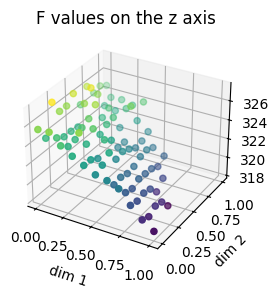

318.3662049951462 327.2323901294801
[0.9        0.4        0.17320508] [0.        0.2       0.9797959]


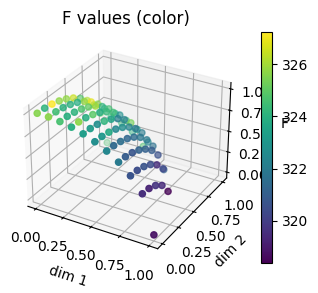

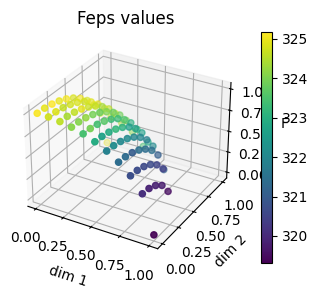

In [1322]:
n = 100
epsilon_f = .2
n_samples = 50
d = 3
x, y = draw_samples(n, d, seed, "gauss")

axis1 = np.arange(0, 1.001, 0.1)
axis2 = np.arange(0, 1.0001, 0.1)
theta1, theta2 = np.meshgrid(axis1, axis2)

all_thetas = np.vstack((theta1.flatten(), theta2.flatten())).T
sum_all_thetas = np.sum(all_thetas**2, axis=1)
all_thetas = all_thetas[np.where(sum_all_thetas <= 1)]
last_dim = np.sqrt(1 - np.sum(all_thetas**2, axis=1))

all_thetas = np.concatenate((all_thetas, last_dim.reshape(-1,1)), axis=1)
Fs = np.array([F(x, y, thetas) for thetas in all_thetas])
Fs_eps = np.array([F_eps(x, y, thetas, epsilon_f, n_samples) for thetas in all_thetas])
grad_Fs_eps = np.array([grad_F_eps(x, y, thetas, epsilon_f, n_samples) for thetas in all_thetas])

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(all_thetas[:,0], all_thetas[:,1], Fs, c = Fs)
ax.set_xlabel('dim 1')
ax.set_ylabel('dim 2')
ax.set_zlabel('F')
ax.set_title('F values on the z axis')
plt.show()
print(np.min(Fs), np.max(Fs))
print(all_thetas[np.argmin(Fs)], all_thetas[np.argmax(Fs)])

ax = plt.figure().add_subplot(projection='3d')
p = ax.scatter(all_thetas[:,0], all_thetas[:,1], all_thetas[:,2], c = Fs)
plt.colorbar(p)
ax.set_xlabel('dim 1')
ax.set_ylabel('dim 2')
ax.set_zlabel('F')
ax.set_title('F values (color)')
plt.show()

ax = plt.figure().add_subplot(projection='3d')
p = ax.scatter(all_thetas[:,0], all_thetas[:,1], all_thetas[:,2], c = Fs_eps)
plt.colorbar(p)
ax.set_xlabel('dim 1')
ax.set_ylabel('dim 2')
ax.set_zlabel('F')
ax.set_title('Feps values')
plt.show()





=> C'est cool : le F_eps lisse vraiment bien le F !

true Wass distance 314.4227662887898


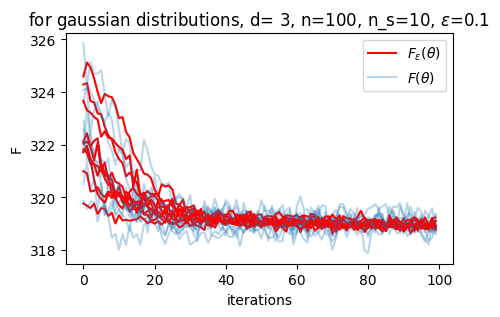

In [1320]:
n = 100
epsilon_f = .1
n_samples = 10
d = 3
x_gauss, y_gauss = draw_samples(n, d, seed, "gauss")

lr_f = 0.005 #learning rate for G


all_Fs = []
all_Fs_eps = []
nb_reps = 10
for th in range(nb_reps):
  th_f = np.random.uniform(size=d)
  th_f = th_f / np.sqrt(np.sum(th_f**2)) 
  nb_steps = 100
  for i in range(nb_steps):
      g = grad_F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples)
      th_f = th_f - lr_f * g
      #th_f = th_f / np.sqrt(np.sum(th_f**2)) 
      all_Fs.append(F(x_gauss, y_gauss, th_f))
      all_Fs_eps.append(F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples))
  if th == 0:
    plt.plot(np.arange(nb_steps), all_Fs_eps, "r", label="$F_\\varepsilon(\\theta)$")
    plt.plot(np.arange(nb_steps), all_Fs, "C0", label="$F(\\theta)$", alpha=0.3)
  else:
    plt.plot(np.arange(nb_steps), all_Fs_eps, "r")
    plt.plot(np.arange(nb_steps), all_Fs, "C0",  alpha=0.3)
  all_Fs = []
  all_Fs_eps = []
plt.legend()
plt.xlabel("iterations")
plt.ylabel("F")
plt.title(f"for gaussian distributions, d= {d}, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_f}")
plt.show()


### Et maintenant, pour $d >> 2$

true Wass distance 699.6095890450168


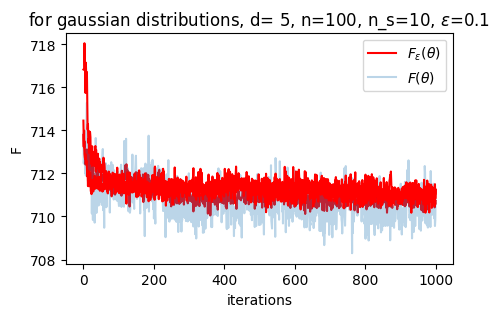

In [1351]:
d = 5

n = 100
epsilon_f = .1
n_samples = 10

x_gauss, y_gauss = draw_samples(n, d, seed, "gauss")

lr_f = 0.01 #learning rate for G


all_Fs = []
all_Fs_eps = []
nb_reps = 3
for th in range(nb_reps):
  th_f = np.random.uniform(size=d)
  th_f = th_f / np.sqrt(np.sum(th_f**2)) 
  nb_steps = 1000
  for i in range(nb_steps):
      g = grad_F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples)
      th_f = th_f - lr_f * g
      #th_f = th_f / np.sqrt(np.sum(th_f**2)) 
      all_Fs.append(F(x_gauss, y_gauss, th_f))
      all_Fs_eps.append(F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples))
  if th == 0:
    plt.plot(np.arange(nb_steps), all_Fs_eps, "r", label="$F_\\varepsilon(\\theta)$")
    plt.plot(np.arange(nb_steps), all_Fs, "C0", label="$F(\\theta)$", alpha=0.3)
  else:
    plt.plot(np.arange(nb_steps), all_Fs_eps, "r")
  all_Fs = []
  all_Fs_eps = []
plt.legend()
plt.xlabel("iterations")
plt.ylabel("F")
plt.title(f"for gaussian distributions, d= {d}, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_f}")
plt.show()


true Wass distance 699.6095890450168


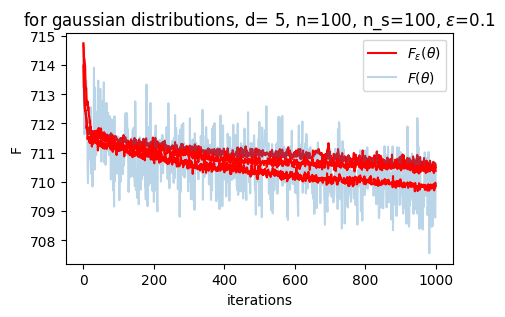

In [1354]:
d = 5

n = 100
epsilon_f = .1
n_samples = 100

x_gauss, y_gauss = draw_samples(n, d, seed, "gauss")

lr_f = 0.02 #learning rate for G


all_Fs = []
all_Fs_eps = []
nb_reps = 3
for th in range(nb_reps):
  th_f = np.random.uniform(size=d)
  th_f = th_f / np.sqrt(np.sum(th_f**2)) 
  nb_steps = 1000
  for i in range(nb_steps):
      g = grad_F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples)
      th_f = th_f - lr_f * g
      #th_f = th_f / np.sqrt(np.sum(th_f**2)) 
      all_Fs.append(F(x_gauss, y_gauss, th_f))
      all_Fs_eps.append(F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples))
  if th == 0:
    plt.plot(np.arange(nb_steps), all_Fs_eps, "r", label="$F_\\varepsilon(\\theta)$")
    plt.plot(np.arange(nb_steps), all_Fs, "C0", label="$F(\\theta)$", alpha=0.3)
  else:
    plt.plot(np.arange(nb_steps), all_Fs_eps, "r")
  all_Fs = []
  all_Fs_eps = []
plt.legend()
plt.xlabel("iterations")
plt.ylabel("F")
plt.title(f"for gaussian distributions, d= {d}, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_f}")
plt.show()


true Wass distance 10172.281749998936


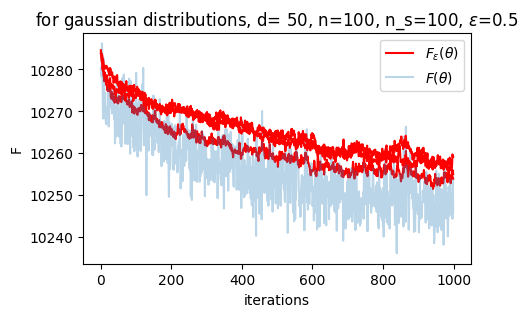

In [1369]:
d = 50

n = 100
epsilon_f = .5
n_samples = 100

x_gauss, y_gauss = draw_samples(n, d, seed, "gauss")

lr_f = 0.1 #learning rate for G


all_Fs = []
all_Fs_eps = []
nb_reps = 3
for th in range(nb_reps):
  th_f = np.random.uniform(size=d)
  th_f = th_f / np.sqrt(np.sum(th_f**2)) 
  nb_steps = 1000
  for i in range(nb_steps):
      g = grad_F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples)
      th_f = th_f - lr_f * g
      #th_f = th_f / np.sqrt(np.sum(th_f**2)) 
      all_Fs.append(F(x_gauss, y_gauss, th_f))
      all_Fs_eps.append(F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples))
  if th == 0:
    plt.plot(np.arange(nb_steps), all_Fs_eps, "r", label="$F_\\varepsilon(\\theta)$")
    plt.plot(np.arange(nb_steps), all_Fs, "C0", label="$F(\\theta)$", alpha=0.3)
  else:
    plt.plot(np.arange(nb_steps), all_Fs_eps, "r")
  all_Fs = []
  all_Fs_eps = []
plt.legend()
plt.xlabel("iterations")
plt.ylabel("F")
plt.title(f"for gaussian distributions, d= {d}, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_f}")
plt.show()


true Wass distance 20704.336748877788


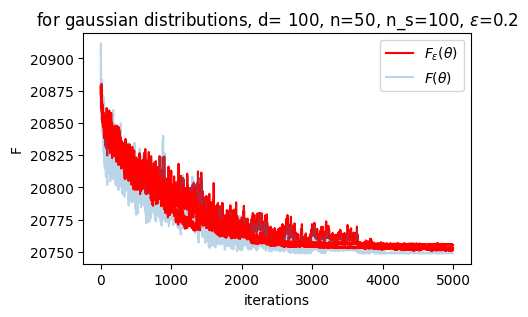

In [1383]:
d = 100

n = 50
epsilon_f = .2
n_samples = 100

x_gauss, y_gauss = draw_samples(n, d, seed, "gauss")

lr_f = 0.02 #learning rate for G


all_Fs = []
all_Fs_eps = []
nb_reps = 3
for th in range(nb_reps):
  th_f = np.random.uniform(size=d)
  th_f = th_f / np.sqrt(np.sum(th_f**2)) 
  nb_steps = 5000
  for i in range(nb_steps):
      g = grad_F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples)
      th_f = th_f - lr_f * g
      all_Fs.append(F(x_gauss, y_gauss, th_f))
      all_Fs_eps.append(F_eps(x_gauss, y_gauss, th_f, epsilon_f, n_samples))
  if th == 0:
    plt.plot(np.arange(nb_steps), all_Fs_eps, "r", label="$F_\\varepsilon(\\theta)$")
    plt.plot(np.arange(nb_steps), all_Fs, "C0", label="$F(\\theta)$", alpha=0.3)
  else:
    plt.plot(np.arange(nb_steps), all_Fs_eps, "r")
  all_Fs = []
  all_Fs_eps = []
plt.legend()
plt.xlabel("iterations")
plt.ylabel("F")
plt.title(f"for gaussian distributions, d= {d}, n={n}, n_s={n_samples}, $\\varepsilon$={epsilon_f}")
plt.show()
